In [1]:
import numpy as np
from pathlib import Path as pt

from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.base import clone

In [2]:
base_loc = pt('/Users/aravindhnivas/Documents/ML-properties/[PHYSICAL CONSTANTS OF ORGANIC COMPOUNDS]/tmp_C_processed_data/analysis_data/filtered/tmpC_topelements_processed_data/embedded_vectors')

# embeddings = 'mol2vec_embeddings'
embeddings = 'VICGAE_embeddings'
processed_vec_dir = base_loc / f'processed_{embeddings}'
X = np.load(processed_vec_dir / 'processed.X.npy', allow_pickle=True)
y = np.load(processed_vec_dir / 'processed.y.npy', allow_pickle=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape


((5760, 32), (5760,), (1440, 32), (1440,))

In [3]:
gbr_model = GradientBoostingRegressor()
xgb_model = XGBRegressor(verbosity=0)
cat_model = CatBoostRegressor(verbose=0)
lgb_model = LGBMRegressor(verbose=-1)

In [4]:
def train_model(model, X_train, y_train):
    cloned_model = clone(model)
    cloned_model.fit(X_train, y_train)
    return

In [5]:
%%timeit
train_model(gbr_model, X_train, y_train)

4.3 s ± 41.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
%%timeit
train_model(xgb_model, X_train, y_train)

263 ms ± 3.61 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
%%timeit
train_model(cat_model, X_train, y_train)

1.6 s ± 17.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
%%timeit
train_model(lgb_model, X_train, y_train)

541 ms ± 14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Apple M2 Pro
32 GB, 10-core CPU

### Mol2vec

GBR: 40.6 s ± 143 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

CATBOOST: 7.94 s ± 411 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

XGBOOST: 1.24 s ± 21.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

LGBM: 861 ms ± 3.94 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

### VICGAE

GBR: 4.3 s ± 41.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

CATBOOST: 1.6 s ± 17.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

XGBOOST: 263 ms ± 3.61 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

LGBM: 541 ms ± 14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [31]:
### Mol2vec
# GBR: 40.6 s ± 143 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# CATBOOST: 7.94 s ± 411 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# XGBOOST: 1.24 s ± 21.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# LGBM: 861 ms ± 3.94 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

# ### VICGAE
# GBR: 4.3 s ± 41.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# CATBOOST: 1.6 s ± 17.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# XGBOOST: 263 ms ± 3.61 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# LGBM: 541 ms ± 14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

models = ['GBR', "CATBOOST", "XGBOOST", "LGBM"]
mol2vec_times = [40.6, 7.94, 1.24, 0.861]
mol2vec_errors = [0.143, 0.411, 0.0212, 0.00394]

vicgae_times = [4.3, 1.6, 0.263, 0.541]
vicgae_errors = [0.0418, 0.0179, 0.00361, 0.014]

# Calculate speedup ratios
speedup_ratios = [m/v for m, v in zip(mol2vec_times, vicgae_times)]
speedup_ratios

[9.44186046511628, 4.9625, 4.7148288973384025, 1.5914972273567467]

In [44]:
import matplotlib.pyplot as plt
from uncertainties import unumpy as unp
from matplotlib.ticker import AutoMinorLocator

mol2vec  = unp.uarray(mol2vec_times, mol2vec_errors)
vicgae = unp.uarray(vicgae_times, vicgae_errors)

mean, std = [], []
for m, v in zip(mol2vec, vicgae):
    val = m/v
    print(val)
    mean.append(val.nominal_value)
    std.append(val.std_dev)

speedup_ratios = unp.uarray(mean, std)
speedup_ratios

9.44+/-0.10
4.96+/-0.26
4.71+/-0.10
1.59+/-0.04


array([9.44186046511628+/-0.09762269542263158,
       4.9625+/-0.26280603204478764,
       4.7148288973384025+/-0.10337301177585793,
       1.5914972273567467+/-0.04182373356272804], dtype=object)

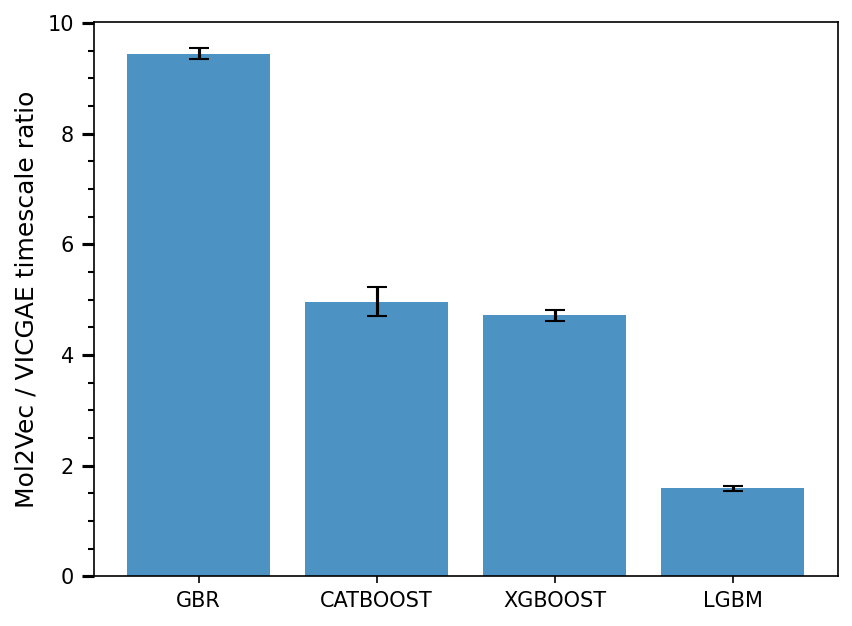

In [67]:
plt.close('all')
fig, ax = plt.subplots(dpi=150)

ax.bar(
    models, 
    unp.nominal_values(speedup_ratios), 
    yerr=unp.std_devs(speedup_ratios), 
    # edgecolor='black', 
    # linewidth=1.5, 
    capsize=5,
    color='C0',
    alpha=0.8
)

# ax.legend()
ax.set_ylabel('Mol2Vec / VICGAE timescale ratio', fontsize=12)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis='y', width=1.5, length=6, which='major')
ax.tick_params(axis='y', width=1, length=3, which='minor')
# ax.set_ybound(lower=0, upper=50)

plots_dir = pt('/Users/aravindhnivas/Documents/ML-properties/plots/')
fig.savefig(plots_dir / 'execution_timescales.pdf', dpi=150, bbox_inches='tight')

plt.show()